In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
from itertools import combinations
import scipy
import scipy.spatial
from sklearn.datasets import load_iris

In [7]:
def load_reg_data():
    # load the regression synthetic data
    torch.manual_seed(0) # force seed so same data is generated every time

    X = torch.linspace(0, 4, 100).reshape(-1, 1)
    noise = torch.normal(0, .4, size=X.shape)
    w = 0.5
    b = 1.
    Y = w * X**2 + b + noise

    return X, Y

def load_xor_data():
    X = torch.tensor([[-1,1],[1,-1],[-1,-1],[1,1]]).float()
    Y = torch.prod(X,axis=1)

    return X, Y

def load_logistic_data():
    torch.manual_seed(0) # reset seed
    return linear_problem(torch.tensor([-1., 2.]), margin=1.5, size=200)

def contour_plot(xmin, xmax, ymin, ymax, pred_fxn, ngrid = 33):
    """
    make a contour plot
    @param xmin: lowest value of x in the plot
    @param xmax: highest value of x in the plot
    @param ymin: ditto for y
    @param ymax: ditto for y
    @param pred_fxn: prediction function that takes an (n x d) tensor as input
                     and returns an (n x 1) tensor of predictions as output
    @param ngrid: number of points to use in contour plot per axis
    """
    # Build grid
    xgrid = torch.linspace(xmin, xmax, ngrid)
    ygrid = torch.linspace(ymin, ymax, ngrid)
    (xx, yy) = torch.meshgrid(xgrid, ygrid)

    # Get predictions
    features = torch.dstack((xx, yy)).reshape(-1, 2)
    predictions = pred_fxn(features)

    # Arrange predictions into grid and plot
    zz = predictions.reshape(xx.shape)
    C = plt.contour(xx, yy, zz,
                    cmap = 'coolwarm')
    plt.clabel(C)
    plt.show()

    return plt.gcf()

def linear_problem(w, margin, size, bounds=[-5., 5.], trans=0.0):
    in_margin = lambda x: torch.abs(w.flatten().dot(x.flatten())) / torch.norm(w) \
                          < margin
    half_margin = lambda x: 0.6*margin < w.flatten().dot(x.flatten()) / torch.norm(w) < 0.65*margin
    X = []
    Y = []
    for i in range(size):
        x = torch.zeros(2).uniform_(bounds[0], bounds[1]) + trans
        while in_margin(x):
            x.uniform_(bounds[0], bounds[1]) + trans
        if w.flatten().dot(x.flatten()) + trans > 0:
            Y.append(torch.tensor(1.))
        else:
            Y.append(torch.tensor(-1.))
        X.append(x)
    for j in range(1):
    	x_out = torch.zeros(2).uniform_(bounds[0], bounds[1]) + trans
    	while not half_margin(x_out):
            x_out = torch.zeros(2).uniform_(bounds[0], bounds[1]) + trans
    	X.append(x_out)
    	Y.append(torch.tensor(-1.))
    X = torch.stack(X)
    Y = torch.stack(Y).reshape(-1, 1)

    return X, Y


In [8]:
def linear_model(w, x):
    
    return torch.matmul(x,w)

def linear_loss(y, y_pred):
    
    return (0.5*(y-y_pred)**2).mean()

## Linear Regression through gradient descent

In [10]:
def linear_gd(X, Y, lrate=0.01, num_iter=1000):
    
    n, d = X.shape
    
    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    w = torch.tensor([[0] for i in range(d+1)], dtype=torch.float32, requires_grad=True)
    
    for epoch in range(num_iter):
    
        y_pred = linear_model(w, X)

        MSELoss = linear_loss(Y, y_pred) 

        MSELoss.backward()
        
        with torch.no_grad():
            
            w -= lrate*w.grad
            
        w.grad.zero_()
        
    return w

 ## Linear Regression through normal equation

In [11]:
def linear_normal(X, Y):
    
    n, d = X.shape

    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
        
    w =  (torch.pinverse(X) @ Y)
    
    return w

In [12]:
def plot_linear():
    
    X, Y = load_reg_data()
    
    w = linear_normal(X,Y)
    
    n, d = X.shape

    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    predicted =(X@w).numpy()
        
    X = X[:,1:].numpy()
    
    Y = Y.numpy()
    
    plt.plot(X, predicted, 'r')
    
    plt.plot(X, Y, 'bo')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Linear Regression')
    
    plt.show()

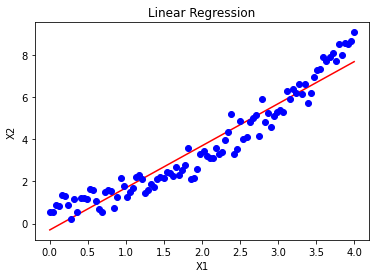

In [13]:
plot_linear()

## Polynomial regression through normal equation

In [14]:
def poly_normal(X, y):
    
    n, d = X.shape
    
    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    new_columns = [i for i in range(1,d+1)] 
    
    index_set = []
    
    if(len(new_columns)>= 2):

        for (i,j) in combinations(new_columns,2):
            index_set.append((i,i))
            index_set.append((j,j))
            index_set.append((i,j))

        index_set = sorted(set(index_set))
        
    else:
        index_set = [(i,i) for i in new_columns]
    
    
    for i in index_set:
                           
        X = torch.cat((X, X[:,i[0]].reshape(-1,1)*X[:,i[1]].reshape(-1,1)), 1)
        
    w = torch.pinverse(X)@y
    
    return w

## Polynomial regression through normal equation

In [15]:
def poly_gd(X, Y, lrate=0.01, num_iter=1000):
    
    n, d = X.shape
    
    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    new_columns = [i for i in range(1,d+1)] 
    
    index_set = []
    
    if(len(new_columns)>= 2):

        for (i,j) in combinations(new_columns,2):
            index_set.append((i,i))
            index_set.append((j,j))
            index_set.append((i,j))

        index_set = sorted(set(index_set))
        
    else:
        index_set = [(i,i) for i in new_columns]
    
    for i in index_set:
                           
        X = torch.cat((X, X[:,i[0]].reshape(-1,1)*X[:,i[1]].reshape(-1,1)), 1)
    
    n, d = X.shape

    w = torch.tensor([[0] for i in range(d)], dtype=torch.float32, requires_grad=True)
    
    for epoch in range(num_iter):
    
        y_pred = linear_model(w, X)

        MSELoss = linear_loss(Y, y_pred) 

        MSELoss.backward()
        
        with torch.no_grad():
            w -= lrate*w.grad
            
        w.grad.zero_()
        
    return w

In [17]:
def plot_poly():
    
    X, Y = load_reg_data()
    
    w = poly_normal(X, Y)
    
    n, d = X.shape
    
    X_temp = X

    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    new_columns = [i for i in range(1,d+1)] 
    
    index_set = []
    
    if(len(new_columns)>= 2):

        for (i,j) in combinations(new_columns,2):
            index_set.append((i,i))
            index_set.append((j,j))
            index_set.append((i,j))

        index_set = sorted(set(index_set))
        
    else:
        index_set = [(i,i) for i in new_columns]
    
    
    for i in index_set:
                           
        X = torch.cat((X, X[:,i[0]].reshape(-1,1)*X[:,i[1]].reshape(-1,1)), 1)
    
    predicted =(X@w).numpy()
    
    
    Y = Y.numpy()
    
    plt.plot(X_temp, predicted, 'r')
    
    plt.plot(X_temp, Y, 'bo')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Polynomial Regression')
    
    plt.show()

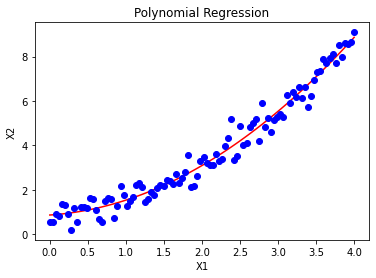

In [18]:
plot_poly()

## Testing models on XOR data

In [19]:
def poly_xor():
    
    X, Y = load_xor_data()
    
    w_linear = linear_normal(X, Y)
    
    w_poly = poly_normal(X, Y)
    
    def linear_pred(features):
        
        n, d = features.shape
        
        a = torch.ones(n).view(n,1)
    
        features = torch.hstack((a, features))
                
        return features@w_linear
    
    def poly_pred(features):
        
        n, d = features.shape
        
        a = torch.ones(n).view(n,1)
    
        features = torch.hstack((a, features))
        
        new_columns = [i for i in range(1,d+1)] 
    
        index_set = []
    
        if(len(new_columns)>= 2):

            for (i,j) in combinations(new_columns,2):
                index_set.append((i,i))
                index_set.append((j,j))
                index_set.append((i,j))

            index_set = sorted(set(index_set))
        
        else:
            index_set = [(i,i) for i in new_columns]
    
    
        for i in index_set:
                           
            features = torch.cat((features, features[:,i[0]].reshape(-1,1)*features[:,i[1]].reshape(-1,1)), 1)
                
        return features@w_poly
        
    
    utils.contour_plot(int(X.min()), int(X.max()), int(Y.min()), int(Y.max()), linear_pred)
    
    utils.contour_plot(int(X.min()), int(X.max()), int(Y.min()), int(Y.max()), poly_pred)
    
    return linear_pred(X), poly_pred(X)

C:\Users\akgo1\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


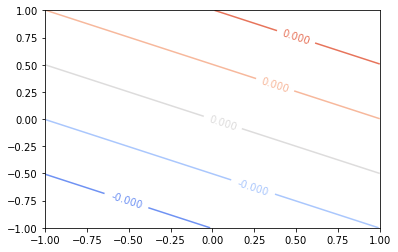

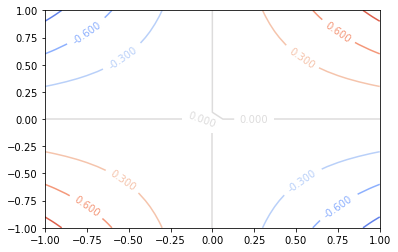

tensor([ 1.4901e-08, -1.4901e-08, -4.4703e-08,  4.4703e-08])
tensor([-1.0000, -1.0000,  1.0000,  1.0000])


<Figure size 432x288 with 0 Axes>

In [20]:
y1, y2 = poly_xor()
print(y1)
print(y2)

## Logistic Regression

In [22]:
def log_model(w, x):
    return torch.matmul(x,w)

def log_loss(y, y_pred):
    return (torch.log(1+torch.exp(-1*y*y_pred))).mean()

In [23]:
def logistic(X, Y, lrate=.01, num_iter=1000):

    n, d = X.shape
    
    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    w = torch.tensor([[0] for i in range(d+1)], dtype=torch.float32, requires_grad=True)
    
    for epoch in range(num_iter):
    
        y_pred = log_model(w, X)

        LogLoss = log_loss(Y, y_pred)

        LogLoss.backward()
        
        with torch.no_grad():
            
            w -= lrate*w.grad
            
        w.grad.zero_()
        
    return w.detach()

## Comparing logistic vs ordinary least squares

In [26]:
def logistic_vs_ols():
    
    X, Y = utils.load_logistic_data()
    
    w_log = logistic(X, Y)
    
    w_linear = linear_gd(X, Y,0.01, 100000)
    
    n, d = X.shape

    a = torch.ones(n).view(n,1)
    
    X = torch.hstack((a, X))
    
    predicted_linear =(X@w_linear).detach().numpy()
    
    predicted_log =(X@w_log).detach().numpy()
    
    X1_log = np.random.choice(X[:,1], size = 100)
    
    X1_linear = np.random.choice(X[:,1], size = 100)
    
    X2_log = -(w_log[0,:].item() + w_log[1,:].item() * X1_log)/w_log[2,:].item()
    
    X2_linear = -(w_linear[0,:].item() + w_linear[1,:].item() * X1_linear)/w_linear[2,:].item()
    
    X = X[:, 1:].numpy()
    
    plt.figure(figsize=(20, 10))
    plt.scatter(X[:,0], X[:,1], c= Y)
    plt.plot(X1_log, X2_log, label = "Logistic")
    plt.ylim([-5.5, 5.5])
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title("Logistic vs. Linear Regression Decision Boundaries")
    plt.plot(X1_linear, X2_linear, 'g', label = "Linear")
    plt.legend()
    
    plt.show()

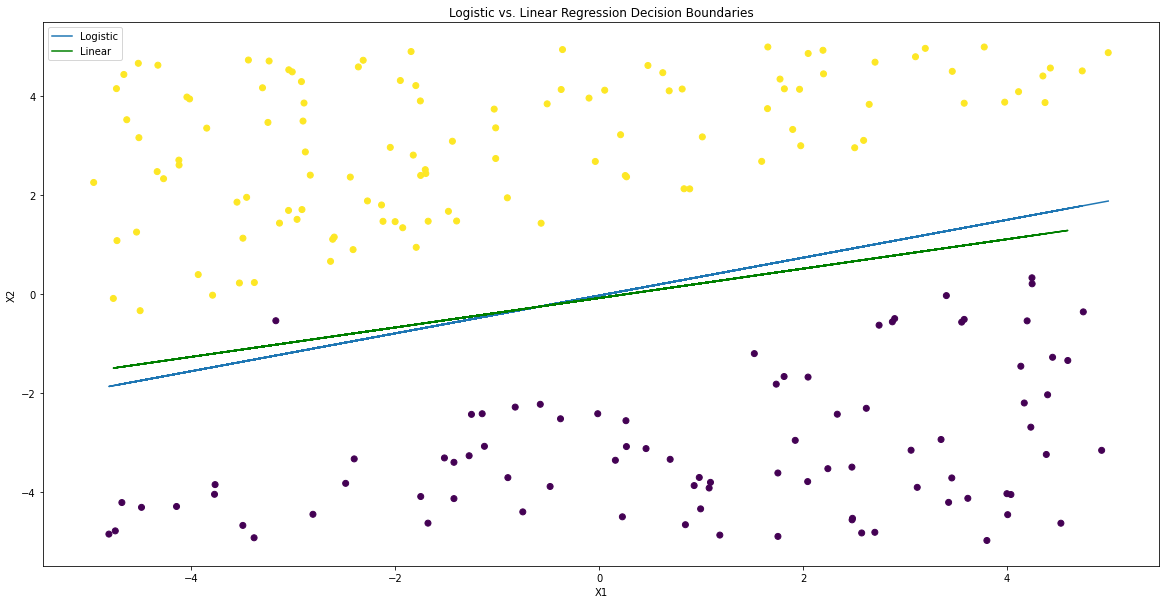

In [25]:
logistic_vs_ols()